# Implementing a Neural Network for CIFAR dataset
In this exercise, you should change H.W_1 to work on the CIFAR dataset.

CIFAR is a dataset that consists of 60,000 32x32 colour images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), with 6000 images per class.

We will have the same components as were in the previous exercise:
- Loading the data and visualize some of the images
- Training the model. Instead of loading a pre-trained model, we will define a new very basic architecture.


## 1) Loading CIFAR dataset

You should load the CIFAR dataset. You can use [the pytorch CIFAR tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). You should define a dictionary of ``dataloaders``. For now, no need to define pre-process to the data. 
Please create a dataloaders disctionary ``{'train','val'}``

You can use batch_size = 128

In [ ]:
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()   # interactive mode
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms

In [ ]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 128 # as requesed

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders = {
    'train': trainloader,
    'val': testloader
  }

dataset_sizes = {
    'train': len(trainset),
    'val': len(testset)
  }

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**If you manage to load the CIFAR data correctly, you should run the next three cells and see some of the images.**



```
# This is formatted as code
```

## Visualize some of the training images

In this dataset the size of the images are 32x32. 

It is important to visualize the data in order to see that we load them correctly (maybe we need to divide by 255? should we make channel permutations?) 

The code below was taken from H.W_1 school solution

Answer: no need to divid by 255, and no need in channel perfumtation

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [ ]:
torch.max(inputs[0])

tensor(1.)

In [ ]:
torch.min(inputs[0])

tensor(-1.)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
# function to plot accuracy
def plot_acc(epoch_acc_ls_train,epoch_acc_ls_val ):
  plt.figure()
  plt.title("epoch_acc train & validation")
  plt.xlabel("epoch num")
  plt.plot(epoch_acc_ls_train,'-*')
  plt.plot(epoch_acc_ls_val,'-*')
  plt.legend(["epoch_acc_ls_train","epoch_acc_ls_val"])


In [ ]:
# function to plot loss
def plot_loss(epoch_loss_ls_train,epoch_loss_ls_val):
    plt.figure()
    plt.title("epoch_loss train & validation")
    plt.xlabel("epoch num")
    plt.plot(epoch_loss_ls_train,'-*')
    plt.plot(epoch_loss_ls_val,'-*')
    plt.legend(["epoch_loss_ls_train","epoch_loss_ls_val"])



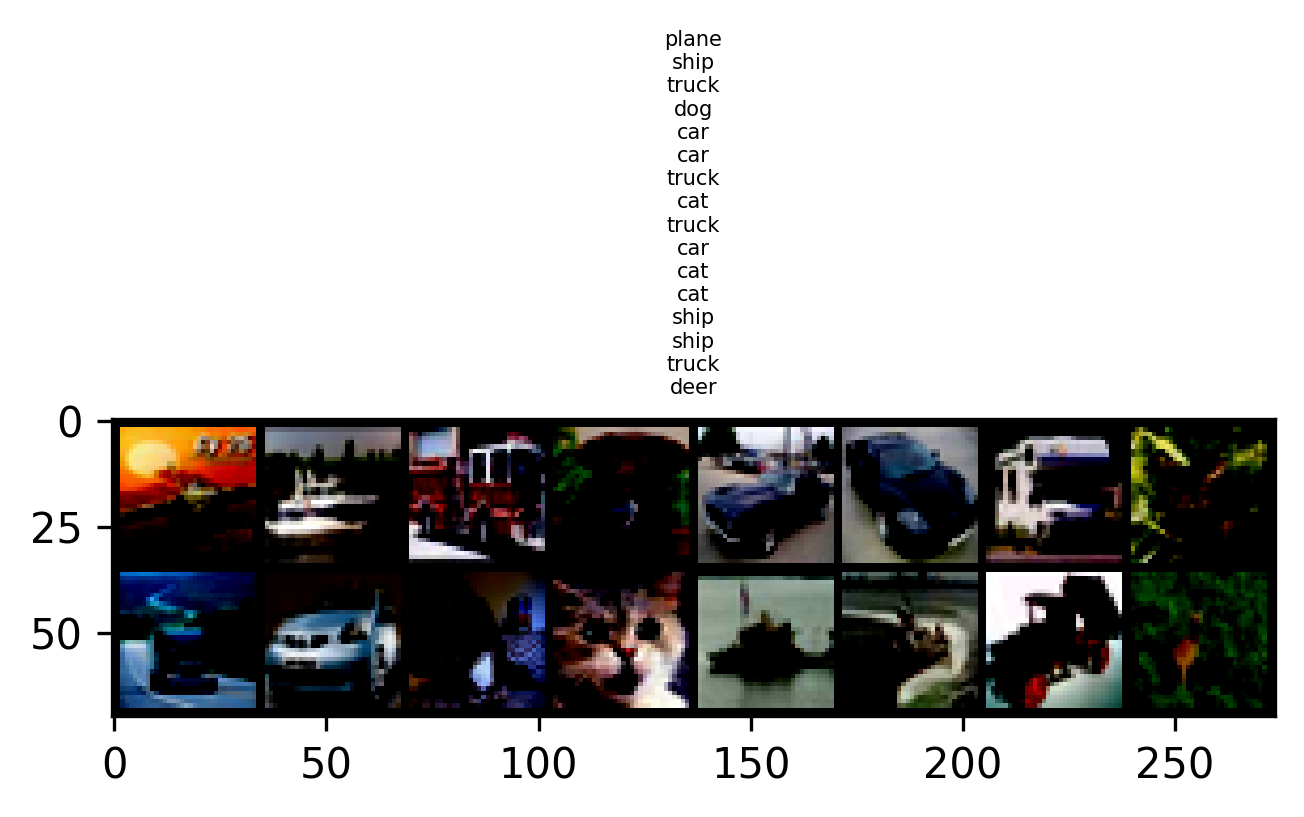

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

## A 2-layer Neural Network

We will define 2-fully-connected-layer network using Sequential module. We have two hidden layers: the first one has 100 neurons and the second one has 20 neurons. The last layer is the output that has 10 elements.

Please pay attention that we take images after flattening (line 15 below).

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


**Pay attention, when you train a network and change something in the parameters, the data, data loaders, image transform, optimizations and more...you should load the model again so it will start from random weights and not from the last training**.

**You should run again the line** ``model = NeuralNetwork().to(device)``


The next two cells (defining the loss and the training loop) were copied from last exercise. 


In [ ]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# train
model = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 2.2938 Acc: 0.1244
val Loss: 2.2783 Acc: 0.1519

Epoch 1/9
----------
train Loss: 2.2654 Acc: 0.1587
val Loss: 2.2520 Acc: 0.1678

Epoch 2/9
----------
train Loss: 2.2405 Acc: 0.1752
val Loss: 2.2274 Acc: 0.1844

Epoch 3/9
----------
train Loss: 2.2160 Acc: 0.1920
val Loss: 2.2020 Acc: 0.2009

Epoch 4/9
----------
train Loss: 2.1901 Acc: 0.2081
val Loss: 2.1749 Acc: 0.2175

Epoch 5/9
----------
train Loss: 2.1628 Acc: 0.2240
val Loss: 2.1467 Acc: 0.2357

Epoch 6/9
----------
train Loss: 2.1346 Acc: 0.2404
val Loss: 2.1179 Acc: 0.2497

Epoch 7/9
----------
train Loss: 2.1189 Acc: 0.2503
val Loss: 2.1150 Acc: 0.2503

Epoch 8/9
----------
train Loss: 2.1160 Acc: 0.2521
val Loss: 2.1122 Acc: 0.2524

Epoch 9/9
----------
train Loss: 2.1132 Acc: 0.2536
val Loss: 2.1093 Acc: 0.2543

Training complete in 2m 54s
Best val Acc: 0.254300


You can continue after you see your model learns something (the training loss is decreasing).

# 2) Losses in Pytorch

Now that you managed to run the training loop, let's understand the loss definition. PyTorch provides losses such as cross-entropy loss (`nn.CrossEntropyLoss`) that has just been used. You'll usually see the loss assigned to `criterion`. For classification problems such as CIFAR, we use the softmax function to predict class probabilities. With a softmax output, we need to use cross-entropy as the loss. To actually calculate the loss, we first define the criterion, then pass in it the output of your network and the correct labels.

*Important note!* Look at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

It means that we need to pass in `nn.CrossEntropyLoss` the raw output of our network into, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities, which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually better to avoid doing calculations with probabilities, and generally we use log-probabilities.

**Exercise:** Change the network above to output the log-softmax and calculate the loss using the negative log-likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.


In [ ]:
## updating the network and loss function:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        #    nn.LogSoftmax(dim=1)  # add a LogSoftmax layer
        )
        self.logsoftloss = nn.LogSoftmax(dim=1)    #<-


# In the forward method, the LogSoftmax layer applies the log softmax function along the dimension 1,
# which represents the classes. The output of this layer is the log probability of each class.
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        log_probs = self.logsoftloss(logits)    #<-
        return log_probs

In [ ]:
#init model
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
  (logsoftloss): LogSoftmax(dim=1)
)


In [ ]:
# define the criterion:
# change the criterion to calculate negative log-likelihood loss
criterion = nn.NLLLoss()

# If a GPU is available, make the model use it
model = model.to(device)

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

# 3) Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.2 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization. 

**Exersice:** Write this visualization here.
(you can copy your solution from last exercies)


In [ ]:
# Adapt the code above to plot the loss and the accuracy every epoch. Show both the training and the validation performance.  

def train_model_NL(model, dataloaders, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_loss_ls_val = []
    epoch_acc_ls_val = []
    epoch_loss_ls_train = []
    epoch_acc_ls_train = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                epoch_loss_ls_train.append(epoch_loss)
                epoch_acc_ls_train.append(epoch_acc.item())
            else:
                epoch_loss_ls_val.append(epoch_loss)
                epoch_acc_ls_val.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_acc_ls_val, epoch_acc_ls_train, epoch_loss_ls_val, epoch_loss_ls_train

In [ ]:
#train
model, epoch_acc_ls_val, epoch_acc_ls_train, epoch_loss_ls_val, epoch_loss_ls_train = train_model_NL(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 2.3022 Acc: 0.1095
val Loss: 2.2946 Acc: 0.1168

Epoch 1/9
----------
train Loss: 2.2866 Acc: 0.1244
val Loss: 2.2804 Acc: 0.1269

Epoch 2/9
----------
train Loss: 2.2718 Acc: 0.1358
val Loss: 2.2653 Acc: 0.1368

Epoch 3/9
----------
train Loss: 2.2551 Acc: 0.1542
val Loss: 2.2473 Acc: 0.1663

Epoch 4/9
----------
train Loss: 2.2355 Acc: 0.1894
val Loss: 2.2261 Acc: 0.2126

Epoch 5/9
----------
train Loss: 2.2128 Acc: 0.2254
val Loss: 2.2017 Acc: 0.2376

Epoch 6/9
----------
train Loss: 2.1870 Acc: 0.2440
val Loss: 2.1742 Acc: 0.2524

Epoch 7/9
----------
train Loss: 2.1715 Acc: 0.2505
val Loss: 2.1713 Acc: 0.2531

Epoch 8/9
----------
train Loss: 2.1686 Acc: 0.2517
val Loss: 2.1683 Acc: 0.2531

Epoch 9/9
----------
train Loss: 2.1656 Acc: 0.2525
val Loss: 2.1653 Acc: 0.2535

Training complete in 3m 7s
Best val Acc: 0.253500


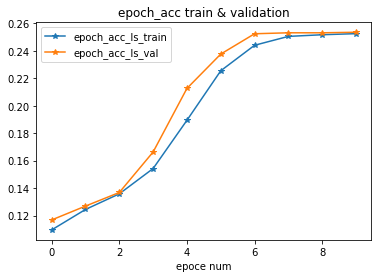

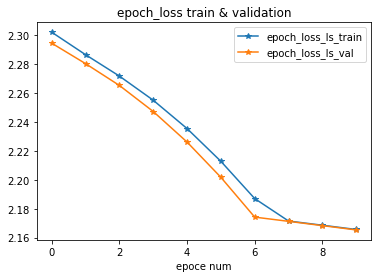

In [ ]:

# plot results
plot_acc(epoch_acc_ls_train,epoch_acc_ls_val )
plot_loss(epoch_loss_ls_train,epoch_loss_ls_val)

# 4) Tune your hyperparameters

**What's wrong?**. Looking at the loss above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy. 

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including *hidden layer size, learning rate, numer of training epochs, and adding l2 or l1 regularization to the cross entropy loss*. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [ ]:

#################################################################################
# TODO: Tune hyperparameters using the validation set.                          #
#     

                                                                          #
#                                                                               #
#################################################################################
# Your code
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

In [ ]:
# i want to still print all 10 epochs loss & Acc so i can check if we are not overfitting during the epochs

## Summary of Results:

1) lr=0.002

2) adding more power to the nn (1000 neurons in hidden layer)


3) no regularization

final score accuracy>0.55

## These are the tryings until reaching final tuning:

 ## 1) Adding more Epochs 
after running 10 more epoch the results are pretty much the same. we guess the lr is too small.

In [ ]:
# model = NeuralNetwork().to(device) ## will not reset the weights just run the training function again

In [ ]:
#train
model, epoch_acc_ls_val, epoch_acc_ls_train, epoch_loss_ls_val, epoch_loss_ls_train = train_model_NL(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


In [ ]:
plot_acc(epoch_acc_ls_train,epoch_acc_ls_val )
plot_loss(epoch_loss_ls_train,epoch_loss_ls_val)

## 2) Changing LR:

-> after running the code below we saw that increasing the learning rate increased the val accuracy
we choose to take a learning rate of 0.1 


In [ ]:
model = NeuralNetwork().to(device) ## reset the weights

In [ ]:
for LR in np.logspace(-1, -3, num=10):
    optimizer_ft = optim.SGD(model.parameters(), lr=LR, momentum=0.9)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    model, epoch_acc_ls_val, epoch_acc_ls_train, epoch_loss_ls_val, epoch_loss_ls_train = train_model_NL(model, 
                        dataloaders,
                          criterion, 
                          optimizer_ft, 
                          exp_lr_scheduler,
                          num_epochs=8)
    plt.figure()
    plt.title("epoch_acc train & validation")
    plt.xlabel("epoce num")
    plt.plot(epoch_acc_ls_train,'-*')
    plt.plot(epoch_acc_ls_val,'-*')
    plt.legend(["epoch_acc_ls_train","epoch_acc_ls_val"])

## 3) Adding regularization term:
regularization doesn't improve the accuracy, and it makes sense, since the model is not yet finished learning/over-fit and regularization also 'limits' its learning process.

In [ ]:
# Initialize the model
model = NeuralNetwork().to(device)
print(model)

In [ ]:
## Updating parameters:
# If a GPU is available, make the model use it
model = model.to(device)

criterion = nn.NLLLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [ ]:
## Updating the training function with L2

def train_model_NL(model, dataloaders, criterion, optimizer, scheduler, num_epochs=5, l2_lambda=0):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_loss_ls_val = []
    epoch_acc_ls_val = []
    epoch_loss_ls_train = []
    epoch_acc_ls_train = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)
                    ### === ADDING REGULARIZATION ====###
                                        ### === ADDING REGULARIZATION ====###
                    if l2_lambda > 0:
                      l2_reg= torch.tensor(0., device = device)
                      for param in model.parameters():
                        l2_reg += torch.norm(param,2)
                        loss = loss + l2_lambda*l2_reg
   
                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                epoch_loss_ls_train.append(epoch_loss)
                epoch_acc_ls_train.append(epoch_acc.item())
            else:
                epoch_loss_ls_val.append(epoch_loss)
                epoch_acc_ls_val.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_acc_ls_val, epoch_acc_ls_train, epoch_loss_ls_val, epoch_loss_ls_train

In [ ]:
L2 = 0.005   # seting l2 param

In [ ]:
# Traing the model with regularization
model, epoch_acc_ls_val, epoch_acc_ls_train, epoch_loss_ls_val, epoch_loss_ls_train = train_model_NL(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=10,
                       l2_lambda = L2)

In [ ]:
# Plot the results
plot_acc(epoch_acc_ls_train,epoch_acc_ls_val )
plot_loss(epoch_loss_ls_train,epoch_loss_ls_val)

In [ ]:
## following the graph above,we need to decress the l2 since it is "hard" for the mode to learn (linear loss and accuracy is worse than without the regularization)

## 4) Giving more power to the network


In [ ]:
## Inlarge the network:
## updating the network and loss function:

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 200), ##<-    200 instead of 100
            nn.ReLU(),
            nn.Linear(200, 20), ##<-   200 instead of 100
            nn.ReLU(),
            nn.Linear(20, 10),
        #    nn.LogSoftmax(dim=1)  # add a LogSoftmax layer
        )
        self.logsoftloss = nn.LogSoftmax(dim=1)    #<-


# In the forward method, the LogSoftmax layer applies the log softmax function along the dimension 1,
# which represents the classes. The output of this layer is the log probability of each class.
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        log_probs = self.logsoftloss(logits)    #<-
        return log_probs

In [ ]:
# Initialize the model
model = NeuralNetwork().to(device)
print(model)

In [ ]:
## Updating parameters:
# If a GPU is available, make the model use it
model = model.to(device)

criterion = nn.NLLLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # lr=0.01

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [ ]:
# Traing the model without regularization
L2=0
model, epoch_acc_ls_val, epoch_acc_ls_train, epoch_loss_ls_val, epoch_loss_ls_train = train_model_NL(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=10,
                       l2_lambda = L2)

In [ ]:
# Plot the results
plot_acc(epoch_acc_ls_train,epoch_acc_ls_val )
plot_loss(epoch_loss_ls_train,epoch_loss_ls_val)

## 5) increasing lr and run again:

In [ ]:
# Initialize the model
model = NeuralNetwork().to(device)
print(model)

In [ ]:
## Updating parameters:
# If a GPU is available, make the model use it
model = model.to(device)

criterion = nn.NLLLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)  # lr=0.05

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [ ]:
# Traing the model without regularization
L2=0
model, epoch_acc_ls_val, epoch_acc_ls_train, epoch_loss_ls_val, epoch_loss_ls_train = train_model_NL(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=10,
                       l2_lambda = L2)

In [ ]:
# Plot the results
plot_acc(epoch_acc_ls_train,epoch_acc_ls_val )
plot_loss(epoch_loss_ls_train,epoch_loss_ls_val)

## 5) Giving more power to the net and no regularization

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 1000),
            nn.ReLU(),
            nn.Linear(1000, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# Initialize the model
model = NeuralNetwork().to(device)
print(model)

In [ ]:
## Updating parameters:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
# increasing initial lr = 0.001*2
optimizer_ft = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
# Traing the model with regularization
L2=0
model, epoch_acc_ls_val, epoch_acc_ls_train, epoch_loss_ls_val, epoch_loss_ls_train = train_model_NL(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=18,
                       l2_lambda = L2)

In [ ]:
# Plot the results
plot_acc(epoch_acc_ls_train,epoch_acc_ls_val )
plot_loss(epoch_loss_ls_train,epoch_loss_ls_val)

## TO SUMMARIZE
giving more power to the network, increassing the lr and adding l2 regularization (with enough epoch) boost the initial results from 0.2 to >0.5

# Interview Question

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

*Your answer*:

**If the gap is too high, it means we might have over-fitting.**

**to avoid this overfitting we can:**

(1) traing on a larger dataset

(3) increase the regularization strenght

and another possible option is to apply "early stopping" in the training epochs.


*Your explanation:*

 **- Adding more hidden units is not guaranteed to decrease the gap between testing accuracy and training accuracy. In fact, it can lead to overfitting, which may increase the gap.**
